## Part 3: TF-IDF

In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import os
from collections import Counter
import nltk, re
from nltk.corpus import stopwords
from nltk import word_tokenize

import networkx as nx
import netwulf as nw
import community as community_louvain

from wordcloud import WordCloud

In [2]:
css_papers = pd.read_excel("CSS_Papers.xlsx")
css_papers.keywords = [eval(css_papers.keywords[i]) for i in range(len(css_papers))]
css_papers.authorIds = [eval(css_papers.authorIds[i]) for i in range(len(css_papers))]
css_papers.author_fields = [eval(css_papers.author_fields[i]) for i in range(len(css_papers))]
css_papers

,Unnamed: 0,paperId,title,year,citationCount,externalIds.DOI,keywords,authorIds,author_fields
0,8287,c816d0003083c3a92ade5f3dbc8419cb5cd91b11,Estimation and Testing for the Cointegration R...,2009,23,NaN,"[Mathematics, Economics]",[2143569],[Economics]
1,10998,843f972bd9688a3c26798c93fed09f070ca79c8b,Real life challenges in access-control management,2009,77,10.1145/1518701.1518838,"[Political Science, Computer Science]","[1746214, 2833225, 1699751, 1778110, 41224057]","[Computer Science, Computer Science, Computer ..."
2,15247,40570ef9dede55251d4c3a8de05da82a56fdc7b0,A Sampling-Based Approach to Computing Equilib...,2009,26,NaN,"[Computer Science, Economics]","[144652072, 21889436]","[Computer Science, Computer Science]"
3,17603,018c0da501bd067daf3b1bfb96fe73760b8abf71,Security Economics and Critical National Infra...,2009,52,10.1007/978-1-4419-6967-5_4,[Economics],[144913176],[Computer Science]
4,17607,4af26bf68b04308cae8825cdfa2db3679a8588bd,Technical perspectiveA chilly sense of security,2009,36,10.1145/1506409.1506428,[Economics],[144913176],[Computer Science]
...,...,...,...,...,...,...,...,...,...
19995,2328370,59fede767933818e5de9c5f5fdaf2e7733bd730e,Is cooperation sustained under increased mixin...,2023,0,10.1016/j.amc.2022.127604,[Economics],[1689559],[Computer Science]
19996,2402573,1cc8ece6cffe84e38b104f58f38884d92674e1f1,Visualizing the knowledge structure of anti-mo...,2023,0,10.1117/12.2655909,[Economics],[5524736],[Computer Science]
19997,2426569,cf543de342436b8ed44c8f6e83c6a54935d39c73,Spatiotemporal Evolution and Determinants of t...,2023,0,10.3390/systems11010033,[Economics],[1736467],[Computer Science]
19998,2488069,08a51de6f966f298baf711b80b00fc5701aa663c,#EndSARS Protest: Discourse and Mobilisation o...,2023,0,NaN,[Political Science],[52143529],[Computer Science]


In [3]:
filename = "shared_data\\author_subset.pkl"

file = open(filename, 'rb')
AuthorData = pkl.load(file)
file.close()

AuthorData

,authorId,name,aliases,citationCount,top_field
0,1779533,N. Mavridis,"[N. Mavridis, Nikolaos Antar Mavridis, Nikolao...",2231,Computer Science
0,3166734,R. Hogarth,"[R. M. Hogarth, Robin M. Hogarth, Robin Hogart...",20586,Psychology
0,1801245727,Jean-Pierre Chevrot,[Jean Pierre Chevrot],610,Linguistics
0,1788563,Ella Haig,"[M Cocea, Mihaela Cocea]",1991,Computer Science
0,143886606,Saquib Razak,None,312,Computer Science
...,...,...,...,...,...
0,72048244,Rachel Krohn,[Rachel. Krohn],28,Computer Science
0,123416689,Friedrich Kurrent,None,0,NaN
0,66245363,J. Morris,"[J Morris, J. C. Moreno C. Morris, John Morris]",430,Medicine
0,11619416,Lang-ping Wang,"[Lang Ping Wang, Lang-ping Wang, Langping Wang]",675,Materials Science


### Exercise 4: TF-IDF and the Computational Social Science communities.
The goal for this exercise is to find the words charachterizing each of the communities of Computational Social Scientists. What you ned for this exercise:
* The assignment of each author to their network community, and the degree of each author (Week 6, Exercise 4). This can be stored in a dataframe or in two dictionaries, as you prefer.
* the tokenized abstract dataframe (Week 7, Exercise 2)

In [4]:
abstracts = pd.read_csv('CSS_Abstracts.csv', index_col=0)

file = open('Network.pkl', 'rb')
G = pkl.load(file)
file.close()

partition = community_louvain.best_partition(G, random_state=0)

1. First, check out the wikipedia page for TF-IDF. Explain in your own words the point of TF-IDF.
* What does TF stand for?

TF (Term Frequency) refers to the frequency of a term (i.e., a word or phrase) in a document. It is calculated as the number of times a term appears in a document divided by the total number of terms in that document. TF assigns a weight to each term in a document based on how frequently it appears in that document.

The TF is typically calculated as:
$$\texttt{tf}(t,d)=\frac{f_{t,d}}{\sum_{t'\in d}f_{t',d}}$$
where $f_{t,d}$ is the raw count of a term $t$ in a document $d$ and $\sum_{t'\in d}f_{t',d}$ is the total number of terms in a document.

* What does IDF stand for?

IDF (Inverse Document Frequency) measures the importance of a term across a collection of documents. It is calculated as the logarithm of the total number of documents divided by the number of documents that contain the term. IDF assigns a weight to each term in a collection of documents based on how common or rare it is across all documents. Terms that are rare across documents (i.e., appear in few documents) are given higher weights than terms that are common across documents (i.e., appear in many documents).

IDF is typically calculated as:
$$\texttt{idf}(t,D) = \log{\frac{N}{|\{d\in D:t\in d\}|}}$$
where $N=|D|$ is the total number of documents in the collection $D$, and $|\{d\in D:t\in d\}|$ is the number of documents where the term $t$ appears

2. Now, we want to find out which words are important for each community, so we're going to create several *large documents, one for each community*. Each document includes all the tokens of abstracts written by members of a given community.
* Consider a community c
* Find all the abstracts of papers written by a member of community c.
* Create a long array that stores all the abstract tokens
* Repeat for all the communities.

**Note:** Here, to ensure your code is efficient, you shall exploit pandas builtin functions, such as groupby.apply or explode.

In [5]:
print(all(abstracts.paperId == css_papers.paperId))
abstracts['authorIds'] = css_papers.authorIds
abstracts['author_fields'] = css_papers.author_fields
abstracts.head()

True


,paperId,abstract,year,tokens,authorIds,author_fields
0,c816d0003083c3a92ade5f3dbc8419cb5cd91b11,The paper generalises estimation and inference...,2009,"['paper', 'generalises', 'estimation', 'infere...",[2143569],[Economics]
1,843f972bd9688a3c26798c93fed09f070ca79c8b,In this work we ask the question: what are the...,2009,"['work', 'ask', 'question', 'challenges', 'man...","[1746214, 2833225, 1699751, 1778110, 41224057]","[Computer Science, Computer Science, Computer ..."
2,40570ef9dede55251d4c3a8de05da82a56fdc7b0,A central task of artificial intelligence is t...,2009,"['central', 'task', 'artificial', 'intelligenc...","[144652072, 21889436]","[Computer Science, Computer Science]"
3,018c0da501bd067daf3b1bfb96fe73760b8abf71,NaN,2009,NaN,[144913176],[Computer Science]
4,4af26bf68b04308cae8825cdfa2db3679a8588bd,This neat piece of work emphasizes once more t...,2009,"['neat', 'piece', 'work', 'emphasizes', 'need'...",[144913176],[Computer Science]


In [6]:
exploded_abstracts = abstracts.explode(['authorIds','author_fields'])
exploded_abstracts = exploded_abstracts.groupby(['authorIds'], group_keys=True).apply(lambda x: x)
exploded_abstracts.dropna(subset=['tokens'], inplace=True)

In [7]:
vocab = np.empty(max(partition.values()), dtype=list)

for c in range(max(partition.values())):
    vocab_c = []
    for author in np.array([*partition.keys()])[(np.array([*partition.values()]) == c)]:
        try:
            vocab_c.append(sum(exploded_abstracts.loc[author].tokens.apply(lambda x: [i for i in eval(x)]), []))
        except:
            pass

    vocab[c]= [i for sub in vocab_c for i in sub]

3. Now, we're ready to calculate the TF for each word. Use the method of your choice to find the **top 5 terms** within the top 5 communities (by number of authors).

* Describe similarities and differences between the communities.
* Why aren't the TFs not necessarily a good description of the communities?
* Next, we calculate IDF for every word.
* What base logarithm did you use? Is that important?

In [8]:
ctr = Counter(list(partition.values()))
top5_communitities = [i[0] for i in ctr.most_common(5)]
top5_communitities

[18, 1, 8, 4, 34]

In [9]:
tfs = []

for i, c in enumerate(range(max(partition.values()))):
    frequency = nltk.FreqDist(vocab[c])
    
    for word in frequency.keys():
        frequency[word] = frequency[word]/len(vocab[c])

    tfs.append(frequency)

for i, c in enumerate(top5_communitities):
    print(f"Top 5 terms in community ranked {i+1}:")
    print(sorted(tfs[c], key=tfs[c].get, reverse=True)[:5])
    print()

Top 5 terms in community ranked 1:
['social', 'data', 'media', 'online', 'research']

Top 5 terms in community ranked 2:
['agents', 'show', 'mechanism', 'model', 'information']

Top 5 terms in community ranked 3:
['social', 'data', 'show', 'find', 'model']

Top 5 terms in community ranked 4:
['social', 'network', 'model', 'data', 'different']

Top 5 terms in community ranked 5:
['social', 'data', 'media', 'public', 'information']



For the top 5 communities, similarities and differences xxx.

It can be seen from the top 5 communities' top 5 terms, that TFs are not necessarily a good description of the communities. We see that 4/5 communities have the term 'social' as their most frequent term, 4/5 have the term 'data' amongst their top 5 terms, and 'model' is present in 3/5 of the communities. The TF is likely not a great description of the communities, because all communities are sub-segment of computational social science, where specific language and vocabulary is inherently used across sub-segments.

One way to make the TFs a more reliable measure could be to identify relevant stopwords for the CCS field and remove these further.

In [10]:
from tqdm import tqdm

allwords = set([w for w in vocab[i] for i in range(max(partition.values()))])

def count_dict(vocabulary):
    word_count = {}
    for word in tqdm(allwords):
        word_count[word] = 0
        for document in vocabulary:
            if word in document:
                word_count[word] += 1
    return word_count
 
word_count = count_dict(vocab)

100%|██████████| 6046/6046 [02:16<00:00, 44.21it/s]


In [11]:
idfs = {}
N = len(vocab)

for w in allwords:
    idfs[w] = np.log2(N/(word_count[w]))

idfs

{'sizes': 4.157117225141692,
 'inability': 5.52908600252865,
 'remains': 3.0773900326709582,
 'services': 2.4668017242743074,
 'whereby': 4.4070954781500395,
 'preserving': 4.916109125637897,
 'competition': 3.368621330335404,
 'classifier': 4.487265826834022,
 'incomes': 5.224231421000229,
 'disaster': 4.4466238423366775,
 'matrix': 4.061959992101352,
 'enrichment': 5.916109125637897,
 'choral': 9.61654884377899,
 'query': 4.092986887721977,
 'reconcile': 5.809193921721385,
 'overload': 5.092986887721977,
 'leone': 7.61654884377899,
 'visualizations': 4.8616613416155205,
 'peer': 4.331146624916741,
 'activities': 2.809193921721385,
 'embolden': 9.61654884377899,
 'exceeds': 4.709658248170471,
 'accounted': 5.157117225141692,
 'dm': 6.4466238423366775,
 'capability': 4.124695747449315,
 'deadliest': 8.61654884377899,
 'establishing': 4.001838999663781,
 'krugman': 8.61654884377899,
 'besides': 4.368621330335404,
 'career': 4.916109125637897,
 'connection': 3.916109125637897,
 'atmosphe

For any log-base, the idf value will increase less rapidly as the real inverse document frequency increases. This helps stabelize the range of the idf values calculated. In the above calculation, we use a log-base 2, as this is most commonly used in TF-IDF literature.

However, the choice of base does not matter as long as the choice is consistent, as mathematically we can always change the base using:
$$\log_b(x)=\frac{\log_a(x)}{\log_a(b)}$$

4. We're ready to calculate TF-IDF. Do that for the top 9 communities (by number of authors). Then for each community:
* List the 10 top TF words
* List the 10 top TF-IDF words
* List the top 3 authors (by degree)
* Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?

In [12]:
top9_communitities = [i[0] for i in ctr.most_common(9)]
top9_communitities

[18, 1, 8, 4, 34, 26, 23, 5, 3]

In [13]:
allwords = set([w for w in vocab[i] for i in top9_communitities])

def count_dict(vocabulary):
    word_count = {}
    for word in tqdm(allwords):
        word_count[word] = 0
        for document in vocabulary:
            if word in document:
                word_count[word] += 1
    return word_count
 
word_count_9 = count_dict(vocab[top9_communitities])

idfs = {}
N = len(vocab[top9_communitities])

for w in allwords:
    idfs[w] = np.log2(N/(word_count_9[w]))

100%|██████████| 6046/6046 [00:37<00:00, 162.17it/s]


In [24]:
tdidfs = []

for c in top9_communitities:
    tdidf = {}
    for w in allwords:
        tdidf[w] = tfs[c][w]*idfs[w]
    tdidfs.append(tdidf)

In [33]:
for i, c in enumerate(top9_communitities):
    print(f"Top {i} community:")
    print(f"Top 10 TF words: {sorted(tfs[c], key=tfs[c].get, reverse=True)[:10]}")
    print(f"Top 10 TF-IDF words: {sorted(tdidfs[i], key=tdidfs[i].get, reverse=True)[:10]}")
    authors_in_c = dict(G.degree(np.array([*partition.keys()])[(np.array([*partition.values()]) == c)]))
    k = Counter(authors_in_c)
    top3_authors = [AuthorData[AuthorData.authorId == i[0]].name.iloc[0] for i in k.most_common(3)]
    print(f"Top 3 authors: {top3_authors}")
    print()

Top 0 community:
Top 10 TF words: ['social', 'data', 'media', 'online', 'research', 'work', 'community', 'use', 'people', 'information']
Top 10 TF-IDF words: ['wikipedia', 'feminist', 'ethnography', 'voice', 'fathers', 'parents', 'q', 'youth', 'understandings', 'drug']
Top 3 authors: ['Brian Keegan', 'Brent J. Hecht', 'Neha Kumar']

Top 1 community:
Top 10 TF words: ['agents', 'show', 'mechanism', 'model', 'information', 'optimal', 'social', 'market', 'equilibrium', 'study']
Top 10 TF-IDF words: ['games', 'auction', 'buyers', 'revenue', 'buyer', 'optimal', 'equilibrium', 'fisher', 'agent', 'rule']
Top 3 authors: ['J. Kleinberg', 'Nicole Immorlica', 'Sharad Goel']

Top 2 community:
Top 10 TF words: ['social', 'data', 'show', 'find', 'model', 'information', 'study', 'results', 'using', 'people']
Top 10 TF-IDF words: ['occupations', 'sandy', 'disaster', 'reciprocity', 'refugees', 'contests', 'microcephaly', 'hurricane', 'multiscale', 'reasoning']
Top 3 authors: ['A. Pentland', 'I. Rahwan'

Comment on Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?

### Exercise 5: The Wordcloud. It's time to visualize our results!

* Install the WordCloud module.
* Now, create word-cloud for each community. Feel free to make it as fancy or non-fancy as you like.
* Make sure that, together with the word cloud, you print the names of the top three authors in each community (see my plot above for inspiration).

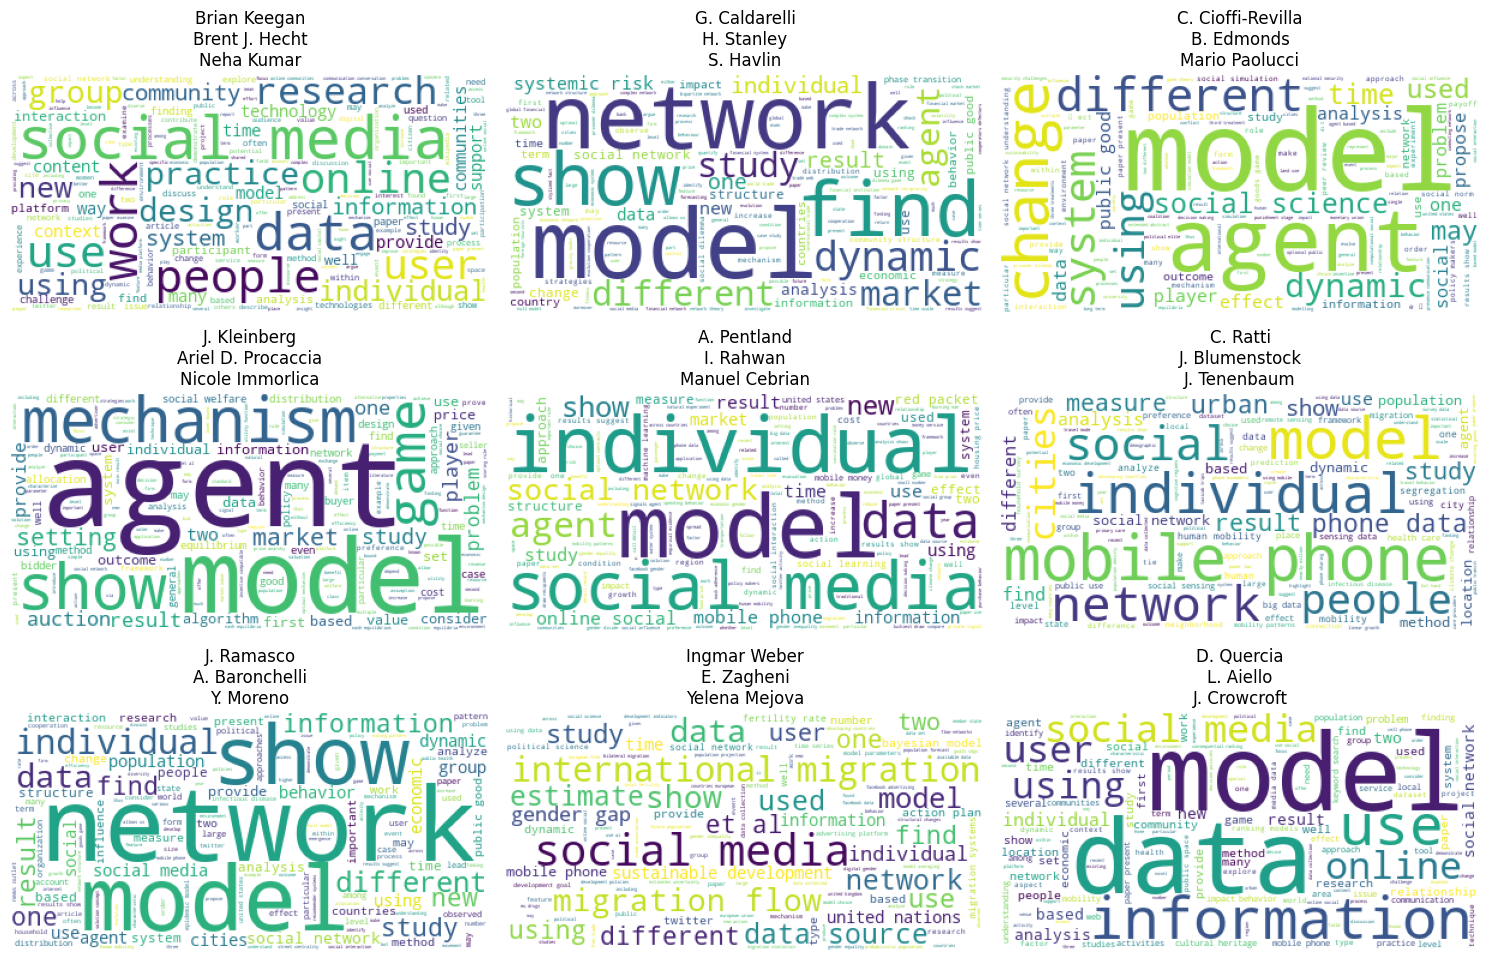

In [21]:
fig, axs = plt.subplots(3,3, figsize = (15, 10), tight_layout = True)
for i, c in enumerate(top9_communitities):
    wordcloud = WordCloud(background_color="white").generate((" ").join(vocab[c]))
    authors_in_c = dict(G.degree(np.array([*partition.keys()])[(np.array([*partition.values()]) == c)]))
    k = Counter(authors_in_c)
    top3_authors = [AuthorData[AuthorData.authorId == i[0]].name.iloc[0] for i in k.most_common(3)]
    axs[i % 3, i // 3].imshow(wordcloud)
    axs[i % 3, i // 3].axis("off")
    string = '\n'
    axs[i % 3, i // 3].set_title(f"{string.join(map(str, top3_authors))}")
plt.show()

#### Comment on your results. What can you conclude on the different sub-communities in Computational Social Science?

xxx

#### Look up online the top author in each community. In light of your search, do your results make sense?

Rank of Community | Author Name | Affiliated Research Centers | Overview of Research 
 :- | :-: | :-: | :-: 
 1 | Brian Keegan | University of Colorado Boulder, and the Colorado Laboratory for Users, Media, and Networks (COLUMN) | Brian Keegan's research focuses on using computational methods to understand and analyze social networks, particularly online networks (i.e. Wikipedia, Reddit, and Twitter). He has three primary foci: (1) high-tempo online collaborations, (2) human-centered data science, and (3) cannabis informatics. He uses digital traces of social behavior to explore how disruptions illuminate the emergence, stabilization, and dissolution of collaborative social structures
 2 | J. Kleinberg | Cornell University | Jon Kleinberg's research spans a wide range of topics in computational social science, including network analysis, machine learning, and the social and economic implications of technology. He is particularly known for his work on information cascades and his contributions to algorithmic game theory. His research focuses on algorithms and networks, the roles they play in large-scale social and information systems, and their broader societal implications. 
 3 | J. Ramasco | Spanish National Research Council CSIC, and Insitute for Cross-Disciplinary Physics and Complex Systems | Jose Ramasco's research focuses on the application of network theory to social phenomena, particularly in the context of urban systems. He is interested in understanding how cities evolve and how people interact within them, and his work has implications for urban planning, transportation, and public health.
 4 | G. Caldarelli | Università Ca’ Foscari Venezia, Complex Systems Society, and European Physical Society | Guido Caldarelli's research focuses on network theory and its applications in a variety of fields, including social science, physics, and economics. He is particularly known for his work on complex networks and his contributions to the study of network structure and dynamics.  
 5 | A. Pentland | MIT | Alex "Sandy" Pentland's research focuses on using big data and machine learning to understand human behavior and social dynamics. He is particularly interested in how data from mobile phones and wearable devices can be used to improve health and well-being, and his work has implications for public policy and business strategy. 
 6 | Ingmar Weber | Qatar Computing Research Institute and Saarland University | Ingmar Weber's research focuses on the intersection of social media and computational social science, with a particular emphasis on issues of privacy, bias, and fairness. He is also interested in using social media data to study political and social movements.  
 7 | C. Cioffi-Revilla | George Mason University | Claudio Cioffi-Revilla's research focuses on the application of computational methods to social science problems, particularly in the field of political science and extreme events in complex systems. He is interested in understanding how social and political systems evolve over time 
 8 | C. Ratti | MIT, Urban Technologies and Planning, and Senseable City Lab | Carlo Ratti's research focuses on the intersection of urban planning, architecture, and technology. He is particularly interested in using data and computational methods to create more responsive and sustainable cities.  
 9 | D. Quercia | University of Cambridge, and Social Dynamics at Nokia Bell Labs | Daniele Quercia's research focuses on the intersection of social media, urban systems, and human behavior. He is interested in using data and machine learning to understand how people interact with their physical and social environments